In [1]:
from functools import partial
from itertools import starmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.ndimage import uniform_filter as unifilt

from iEEG_utils.loading import read_data
from iEEG_utils.processing import filtering, fooof_mod
from fooof.utils import interpolate_spectra
# pymultitaper - https://github.com/fncokg/pymultitaper
from pymultitaper import multitaper_spectrogram

rng = np.random.default_rng()

C:\Users\jmile3\python\envs\iEEG_analysis\Lib\site-packages\GRID_lab_python\iEEG_utils\processing\fooof_mod.py:14: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOFGroup


In [2]:
# use file selection dialog to choose folder with data storage
fstr = read_data.select_directory()
print(fstr)

C:\Users\jmile3\OneDrive - SCH\sEEG_data\Thalamic\2398ec


In [3]:
# IF following JTM's data processing workflow
#### i.e.: 
#### iEEG.csv of timeseries for regions of interest
#### montage.csv of research montage info
#### channels.csv with metadata (loosely following iEEG-BIDS)
# the next line will load the iEEG.csv file and metadata
# can set load_meta = False to just load the timeseries data
# will need sampling rate, though (typically in "channels.csv")

montage = read_data.load_info(fstr,ftype="montage")
montage.name = montage.name.replace(" ","",regex=True)
srate,data = read_data.load_iEEG(fstr,load_meta=True)
# newcols = list(map(lambda x: x.replace(" ",""),data.columns))
data.rename(mapper=dict(zip(data.columns,list(map(lambda x: x.replace(" ",""),data.columns)))),axis='columns',inplace=True)
origtime = pd.to_datetime(data.time,format='%H:%M:%S.%f')
origts = np.array(origtime-origtime[0])/ np.timedelta64(1, 's')

print(srate)
print(data.shape)

display(data.head())

1000
(302000, 20)


,time,LCM3,LCM4,LCM5,LCM6,LCM7,LCM8,LCM12,LCM13,LCM14,RCM3,RCM4,LANT3,LANT4,LANT15,LANT16,RANT1,RANT2,DC1,DC2
0,10:59:28.948976,-1.170983,-4.188510,-8.681272,-9.351833,-14.582213,-7.206036,-7.071924,-4.188510,19.817593,-4.859071,-6.870756,4.528790,-10.290620,5.735801,4.327622,2.382993,-7.273093,-110.271344,-117.513408
1,10:59:28.949976,-6.267250,-8.614216,-13.039922,-14.448101,-17.532684,-9.418890,-13.643427,-7.876598,16.062449,-11.430574,-11.967023,0.103084,-13.911652,1.310095,0.639533,-2.780330,-10.223563,-132.668099,-131.192864
2,10:59:28.950976,-9.217721,-11.564686,-13.777539,-17.398572,-19.745537,-10.827069,-17.264459,-10.827069,13.849596,-15.051606,-14.112820,-2.176825,-17.532684,-2.310937,-2.981499,-6.401363,-13.106978,-109.869007,-97.396563
3,10:59:28.951976,-10.625900,-10.089451,-13.039922,-15.923336,-20.483155,-9.418890,-15.789224,-12.235248,15.257775,-14.984550,-14.112820,-2.914443,-16.795066,-3.786173,-4.456734,-2.780330,-13.106978,-79.760794,-52.737164
4,10:59:28.952976,-12.101136,-10.827069,-16.660954,-18.806751,-22.696008,-12.302304,-18.002077,-15.923336,14.520157,-14.984550,-16.258617,-5.127296,-18.940863,-7.407205,-8.144823,-4.926127,-14.582213,-56.291141,-18.404414


In [4]:
montage

,ID,age,region,ch,name
0,2398ec,19.92,r_centromedian_thal,18,RCM3
1,2398ec,19.92,r_centromedian_thal,19,RCM4
2,2398ec,19.92,l_centromedian_thal,2,LCM3
3,2398ec,19.92,l_centromedian_thal,3,LCM4
4,2398ec,19.92,l_ventroposterolateral_thal,4,LCM5
5,2398ec,19.92,l_ventroposterolateral_thal,5,LCM6
6,2398ec,19.92,l_ventrallateralposterior_thal,6,LCM7
7,2398ec,19.92,l_ventrallateralposterior_thal,7,LCM8
8,2398ec,19.92,l_caudalmiddlefrontal,11,LCM12
9,2398ec,19.92,l_caudalmiddlefrontal,12,LCM13


In [7]:
# rate to resample to (best if power of 2)
resrate = 1024
# upper bound of frequency range (must be < resrate/2)
lpfreq = 150
ch1 = "RANT1"
ch2 = "RANT2"
ts,reref1,_ = filtering.bipolar_reref(data.loc[:,[ch1,ch2]], srate, resrate, lpfreq=lpfreq)


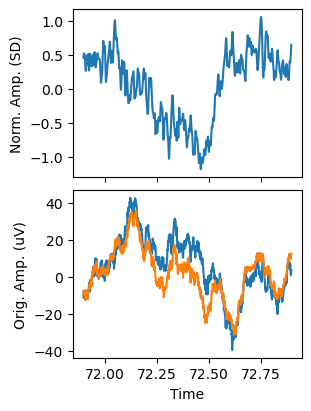

In [9]:
t1 = rng.integers(resrate, high=len(reref1))
t0 = t1-resrate
tfilt = (origts>=ts[t0]) & (origts<=ts[t1])
fig, ax = plt.subplots(2,1,sharex=True,figsize=[3,4],layout='constrained')
ax = ax.flatten()
# reref 1
ax[0].plot(ts[t0:t1],reref1[t0:t1])
ax[1].plot(origts[tfilt], filtering.bfilt(np.array([data.loc[tfilt,ch1],data.loc[tfilt,ch2]]).T,srate,4,[59,61],"stop"))
ax[0].set_xlabel("")
ax[1].set_xlabel("Time")
ax[0].set_ylabel("Norm. Amp. (SD)")
ax[1].set_ylabel("Orig. Amp. (uV)")


plt.show()

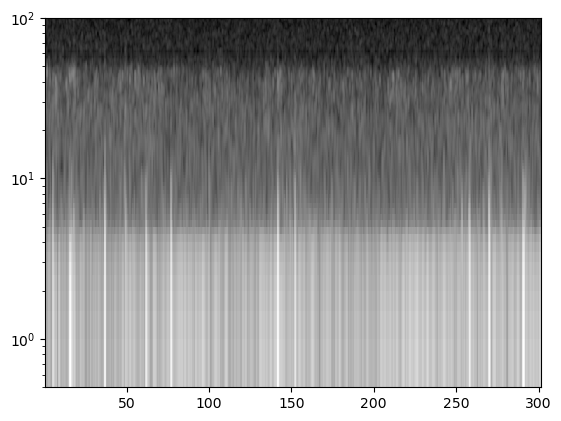

In [10]:
# process data from each subj
# set some parameters that will be used for processing
#####
t_res = 1/4 # time between spectra calculations (seconds)
f_res = 1/2 # frequency bin size for spectra (Hz)
t_win = 1 # in seconds
fmin = 0.5 # minimum frequency to save
fmax = 100 # max frequency to save (should be below 256)
####

f,sts,spectra = multitaper_spectrogram(reref1,resrate,time_step=t_res,window_length=t_win,NW=3,
                                       detrend='off',freq_range=[fmin, fmax],nfft=2*t_win*resrate,
                                       db_scale=False,boundary_pad=False)

# do some light smoothing of adjacent frequencies and timepoints
# (rows are temporally adjacent with t_res (sec) offset
smoothspect = unifilt(spectra, [5,3], mode="nearest",)
# interpolate over 60 Hz line noise to make fitting better
_,spectra = interpolate_spectra(f, smoothspect.T, [58.5,61.5], buffer=5)
fig, ax = plt.subplots()
ax.pcolormesh(sts,f,np.log10(spectra[1:,1:].T),cmap="grey", shading="flat")
ax.set_ylim([fmin,fmax])
ax.set_yscale("log")
plt.show()

In [11]:
# fit 1/f with Lorentzian
spect_fits = fooof_mod.fit_group(f,spectra)


Running FOOOFGroup across 1205 power spectra.


In [12]:
model_spect = fooof_mod.model_spect
intfs = np.concatenate((np.linspace(0.5,1,sum(f>50)+1),np.linspace(1.05,10,sum(f>10)),f[f>10]))
rowixs = [[ix] for ix in range(max(spectra.shape))]
partial_func = partial(model_spect,model_obj=spect_fits,freqs=f,intfs=intfs,save_fit=True)
calc_resids = starmap(partial_func,rowixs)
resid_spects = np.array(list(calc_resids))

C:\Users\jmile3\python\envs\iEEG_analysis\Lib\site-packages\GRID_lab_python\iEEG_utils\processing\fooof_mod.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  reparams,_ = curve_fit(lorentzian_function, intfs, np.log10(intfx(intfs)), p0=[offset,knee,exp], maxfev=2500)
C:\Users\jmile3\python\envs\iEEG_analysis\Lib\site-packages\GRID_lab_python\iEEG_utils\processing\fooof_mod.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  reparams,_ = curve_fit(lorentzian_function, intfs, np.log10(intfx(intfs)), p0=[offset,knee,exp], maxfev=2500)
C:\Users\jmile3\python\envs\iEEG_analysis\Lib\site-packages\GRID_lab_python\iEEG_utils\processing\fooof_mod.py:102: OptimizeWarning: Covariance of the parameters could not be estimated
  reparams,_ = curve_fit(lorentzian_function, intfs, np.log10(intfx(intfs)), p0=[offset,knee,exp], maxfev=2500)
C:\Users\jmile3\python\envs\iEEG_analysis\Lib\site-packages\GRID_lab_python\iEEG_utils\processing\fooof_mod.p

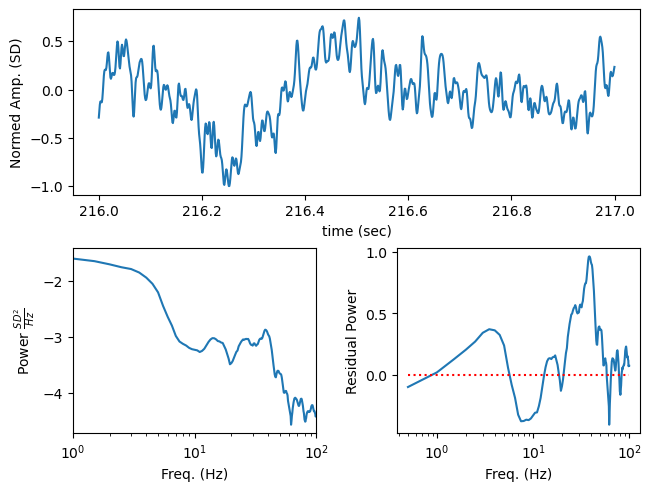

In [24]:
randix = rng.integers(0, high=max(resid_spects.shape))
randt = sts[randix]
plot_ixs = (ts>=randt-(t_win/2))&(ts<=randt+(t_win/2))

fig = plt.figure(layout="constrained")

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(ts[plot_ixs],reref1[plot_ixs])
ax1.set_xlabel("time (sec)")
ax1.set_ylabel("Normed Amp. (SD)")

ax2.plot(f,np.log10(spectra[randix,:]))
ax2.set_xscale("log")
ax2.set_xlim([1,100])
ax2.set_xlabel("Freq. (Hz)")
ax2.set_ylabel("Power "+ r'$\frac{SD^2}{Hz}$')

ax3.plot(f,resid_spects[randix,:])
ax3.plot([f[0],f[-1]],[0,0],"r:")

ax3.set_xlabel("Freq. (Hz)")
ax3.set_ylabel("Residual Power")
ax3.set_xscale("log")


In [ ]:
t0 = 48 #0
t1 = 52 #max(ts)
tfilt = (ts>t0) & (ts<=t1)
stfilt = (sts>=t0) & (sts<=t1)


In [ ]:
from matplotlib.gridspec import GridSpec
fig = plt.figure()
grid = GridSpec(2,1 , height_ratios=[1,4])
ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1],sharex=ax1)

ax1.plot(ts[tfilt],reref[tfilt])
ax1.set_xlim([t0,t1])     
Y,X=np.meshgrid(f, sts[stfilt])
ax2.pcolormesh(X,Y,resid_spects[stfilt,:],vmin=0, vmax=1,
              cmap="grey",shading="nearest")
ax2.set_ylim([fmin,fmax])
ax2.set_yscale("log")
plt.show()

In [16]:
win_samps.shape

(1076, 2048)